In [1]:
import cv2
from skimage import exposure
from skimage.filters import unsharp_mask

import numpy as np
import os
import random

from skimage.metrics import structural_similarity as ssim

C:\Users\DELL\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
class get_original_data_paths():
    
    def run(self):
        
            #############################################

            #Exudates Optha
            #images
            temp=os.listdir("E:/MIT_projects/Diabetic retinopathy/e_ophtha_dataset-20230303T080518Z-001/e_ophtha_dataset/e_ophtha_EX/e_optha_EX/EX")
            temp=["E:/MIT_projects/Diabetic retinopathy/e_ophtha_dataset-20230303T080518Z-001/e_ophtha_dataset/e_ophtha_EX/e_optha_EX/EX/"+temp[i] 
                  for i in range(len(temp))]
            ex_images=[i+"/"+j for i in temp for j in os.listdir(i)]

            #Micro-aneurysms Optha
            #images
            temp=os.listdir("E:/MIT_projects/Diabetic retinopathy/e_ophtha_dataset-20230303T080518Z-001/e_ophtha_dataset/e_ophtha_MA/e_optha_MA/MA")
            temp=["E:/MIT_projects/Diabetic retinopathy/e_ophtha_dataset-20230303T080518Z-001/e_ophtha_dataset/e_ophtha_MA/e_optha_MA/MA/"+temp[i] 
                  for i in range(len(temp))]
            ma_images=[i+"/"+j for i in temp for j in os.listdir(i)]

            ma_images.remove('E:/MIT_projects/Diabetic retinopathy/e_ophtha_dataset-20230303T080518Z-001/e_ophtha_dataset/e_ophtha_MA/e_optha_MA/MA/E0000043/Thumbs.db')


            ##############################################

            #Idrid
            train_imgs = ['E:/MIT_projects/A. Segmentation/1. Original Images/a. Training Set/'+i for i in os.listdir('E:/MIT_projects/A. Segmentation/1. Original Images/a. Training Set')]
            test_imgs = ['E:/MIT_projects/A. Segmentation/1. Original Images/b. Testing Set/'+i for i in os.listdir('E:/MIT_projects/A. Segmentation/1. Original Images/b. Testing Set')]

            ###############################################

            #Complete dataset

            idrid_images = train_imgs + test_imgs
            e_ophtha_images = ex_images + ma_images

            self.images = {'idrid':idrid_images, 'e_ophtha':e_ophtha_images}


In [3]:
paths = get_original_data_paths()
paths.run()
len(paths.images['idrid']) , len(paths.images['e_ophtha'])

(81, 195)

In [4]:
from matplotlib import pyplot as plt

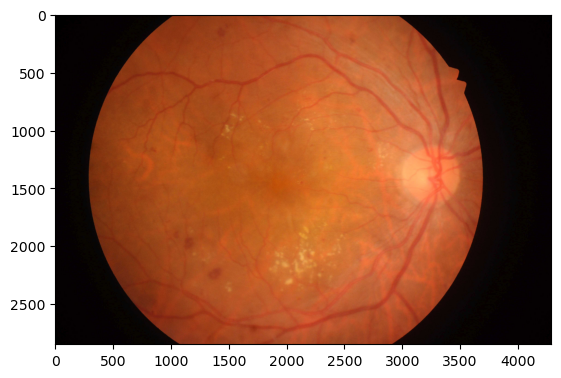

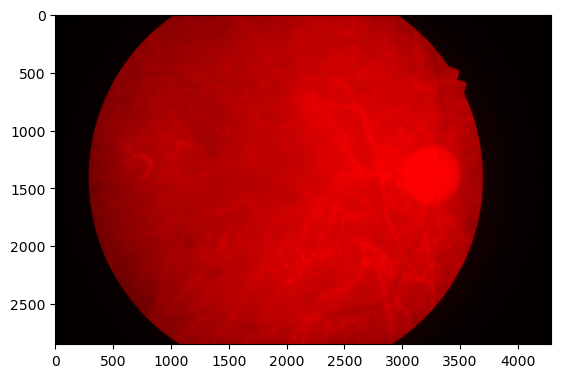

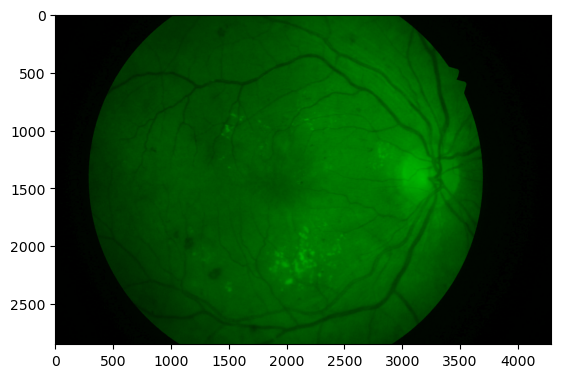

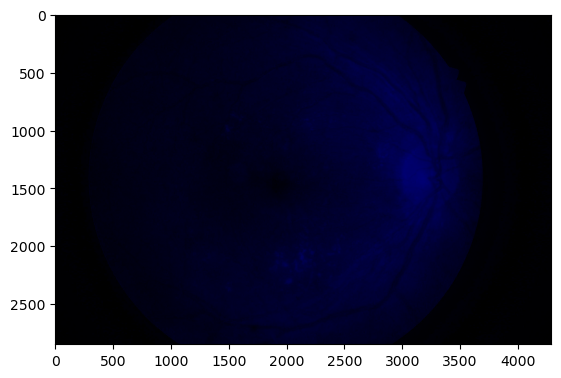

In [5]:
img = cv2.imread(paths.images['idrid'][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

R = np.zeros((img.shape))
R[:,:,0] = img[:,:,0]
R[:,:,1] , R[:,:,2] = R[:,:,1]*0 , R[:,:,2]*0


G = np.zeros((img.shape))
G[:,:,1] = img[:,:,1]
G[:,:,0] , G[:,:,2] = G[:,:,0]*0 , G[:,:,2]*0

B = np.zeros((img.shape))
B[:,:,2] = img[:,:,2]
B[:,:,0] , B[:,:,1] = B[:,:,0]*0 , B[:,:,1]*0

R = (R ).astype(np.uint8)
G = (G).astype(np.uint8)
B = (B).astype(np.uint8)

plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(R)
plt.figure()
plt.imshow(G)
plt.figure()
plt.imshow(B)

In [6]:
cv2.imwrite('RGB.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

True

In [7]:
# Save the R channel as an image
cv2.imwrite('R_channel.jpg', cv2.cvtColor(R, cv2.COLOR_RGB2BGR))

# Save the G channel as an image
cv2.imwrite('G_channel.jpg', G)

# Save the B channel as an image
cv2.imwrite('B_channel.jpg', cv2.cvtColor(B, cv2.COLOR_RGB2BGR))

True

In [4]:
def preprocess(img):
    
        img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # 1. Gaussian filter ---> CLAHE --->  Unsharp-Mask
        gaus_img = cv2.GaussianBlur(img_gray , (5,5) , 0 , borderType = cv2.BORDER_CONSTANT)
        hist_equ = exposure.equalize_adapthist(gaus_img)
        unsharp_bilat = unsharp_mask(hist_equ , radius=7 , amount=2 )

        # 2. Split channels ---> Median Blur 2x ---> CLAHE --->  Gamma filter
        r,g,b = cv2.split(img)
        img_med = cv2.medianBlur(g,3)
        img_med_1 = cv2.medianBlur(img_med,3)
        clahe = cv2.createCLAHE(clipLimit=2,tileGridSize= (8,8))
        cl_img = clahe.apply(img_med_1)
        gamma_img = np.array(255*(cl_img/255)**0.8,dtype='uint8')


        #Merging the 3 pre-processed imgs
        l,m = gamma_img.shape
        final_img=np.ones((l,m,3))
        final_img[:,:,0]=final_img[:,:,0]*gamma_img
        final_img[:,:,1]=final_img[:,:,1]*unsharp_bilat
        final_img[:,:,2]=final_img[:,:,2]*g


        d1,d2,d3 = cv2.split(final_img)

        permutations = [
                            (d1, d2, d3),
                            (d1, d3, d2),
                            (d2, d1, d3),
                            (d2, d3, d1),
                            (d3, d1, d2),
                            (d3, d2, d1)
                        ]
        
        temp_list=[]
        for i in range(6):
            preprocessed_img = cv2.merge(permutations[i]).astype(np.uint8)
            preprocessed_img = cv2.cvtColor(preprocessed_img, cv2.COLOR_RGB2GRAY)
            ssim_score = ssim( img_gray , preprocessed_img )
            temp_list.append(ssim_score)
            
        return temp_list
    
    
def calculate_entropy(image):
    
    flattened_image = image.flatten()
    histogram = np.histogram(flattened_image, bins=256, range=(0, 255))[0]
    histogram = histogram / float(np.sum(histogram))
    histogram = histogram[np.nonzero(histogram)]
    entropy = -np.sum(histogram * np.log2(histogram))

    return entropy

In [7]:
en_list = []
for i in range(54):
        img = cv2.imread(paths.images['idrid'][i])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        en = calculate_entropy(img)
        en_list.append(en)
en_arr = np.array(en_list)
mean = np.mean(en_list,axis=0)
print(mean)

5.989520021744394


In [8]:
en_list = []
for i in range(47):
        img = cv2.imread(paths.images['e_ophtha'][i])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        en = calculate_entropy(img)
        en_list.append(en)
en_arr = np.array(en_list)
mean = np.mean(en_list,axis=0)
print(mean)

5.155590806894587


## IDRiD 

In [5]:
ssim_list_idrid = []

for i in range(len(paths.images['idrid'][:54])):
        img = cv2.imread(paths.images['idrid'][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ssim_score = preprocess(img)
        ssim_list_idrid.append(ssim_score)

In [6]:
ssim_arr_idrid = np.array(ssim_list_idrid)
mean_ssim_idrid = np.mean(ssim_arr_idrid,axis=0)
print(mean_ssim_idrid)

[0.69078041 0.86765524 0.74402434 0.87381167 0.76437846 0.70333971]


## e-Ophtha

In [7]:
ssim_list_e_ophtha = []

for i in range(len(paths.images['e_ophtha'][:47])):
        img = cv2.imread(paths.images['e_ophtha'][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ssim_score = preprocess(img)
        ssim_list_e_ophtha.append(ssim_score)

In [8]:
ssim_arr_e_ophtha = np.array(ssim_list_e_ophtha)
mean_ssim_e_ophtha = np.mean(ssim_arr_e_ophtha,axis=0)
print(mean_ssim_e_ophtha)

[0.7300988  0.81795768 0.6760131  0.89386644 0.67158082 0.77684231]


# Test Code

In [5]:
def calculate_psnr(original_img, processed_img):
    mse = np.mean((original_img - processed_img) ** 2)
    max_pixel_value = 255.0
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr

def calculate_correlation(original_img, processed_img):
    original_flat = original_img.flatten()
    processed_flat = processed_img.flatten()
    correlation = np.corrcoef(original_flat, processed_flat)[0, 1]
    return correlation

def edge_preservation_index(ref_image, processed_image):
    
    # Compute gradient magnitude images
    ref_grad = cv2.Laplacian(ref_image, cv2.CV_64F)
    processed_grad = cv2.Laplacian(processed_image, cv2.CV_64F)
    
    # Calculate the edge preservation index
    epi = np.sum(np.abs(ref_grad) - np.abs(processed_grad)) / np.sum(np.abs(ref_grad))
    
    return epi

def calculate_entropy(image):
    
    flattened_image = image.flatten()
    histogram = np.histogram(flattened_image, bins=256, range=(0, 255))[0]
    histogram = histogram / float(np.sum(histogram))
    histogram = histogram[np.nonzero(histogram)]
    entropy = -np.sum(histogram * np.log2(histogram))

    return entropy

def calculate_ssim(reference_img, processed_img):
    
    ssim_score = ssim(reference_img, processed_img)
    
    return ssim_score
    
    

def preprocess(img):
    
        img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # 1. Gaussian filter ---> CLAHE --->  Unsharp-Mask
        gaus_img = cv2.GaussianBlur(img_gray , (5,5) , 0 , borderType = cv2.BORDER_CONSTANT)
        hist_equ = exposure.equalize_adapthist(gaus_img)
        unsharp_bilat = unsharp_mask(hist_equ , radius=7 , amount=2 )

        # 2. Split channels ---> Median Blur 2x ---> CLAHE --->  Gamma filter
        r,g,b = cv2.split(img)
        img_med = cv2.medianBlur(g,3)
        img_med_1 = cv2.medianBlur(img_med,3)
        clahe = cv2.createCLAHE(clipLimit=2,tileGridSize= (8,8))
        cl_img = clahe.apply(img_med_1)
        gamma_img = np.array(255*(cl_img/255)**0.8,dtype='uint8')


        #Merging the 3 pre-processed imgs
        l,m = gamma_img.shape
        final_img=np.ones((l,m,3))
        final_img[:,:,0]=final_img[:,:,0]*gamma_img
        final_img[:,:,1]=final_img[:,:,1]*unsharp_bilat
        final_img[:,:,2]=final_img[:,:,2]*g


        d1,d2,d3 = cv2.split(final_img)

        permutations = [
                            cv2.cvtColor(cv2.merge((d1, d2, d3)).astype(np.uint8), cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(cv2.merge((d1, d3, d2)).astype(np.uint8), cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(cv2.merge((d2, d1, d3)).astype(np.uint8), cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(cv2.merge((d2, d3, d1)).astype(np.uint8), cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(cv2.merge((d3, d1, d2)).astype(np.uint8), cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(cv2.merge((d3, d2, d1)).astype(np.uint8), cv2.COLOR_RGB2GRAY)
                        ]
        

        
        psnr_list = [calculate_psnr(img_gray, perm) for perm in permutations]
        correlation_list = [calculate_correlation(img_gray, perm) for perm in permutations]
        epi_list = [edge_preservation_index(img_gray, perm) for perm in permutations]
        entropy_list = [calculate_entropy(perm) for perm in permutations]
        ssim_list = [calculate_ssim(img_gray, perm) for perm in permutations]

 
            
        return psnr_list, correlation_list, epi_list, entropy_list, ssim_list

## IDRiD

In [6]:
psnr_list=[]
correlation_list=[]
epi_list=[]
entropy_list=[]
ssim_list=[]

for i in range(len(paths.images['idrid'][:54])):
        img = cv2.imread(paths.images['idrid'][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        psnr_scores, correlation_scores, epi_scores, entropy_scores, ssim_scores = preprocess(img)
    
        psnr_list.append(psnr_scores)
        correlation_list.append(correlation_scores)
        epi_list.append(epi_scores)
        entropy_list.append(entropy_scores)
        ssim_list.append(ssim_scores)

In [7]:
psnr_arr = np.array(psnr_list)
mean_psnr = np.mean(psnr_arr, axis=0)

correlation_arr = np.array(correlation_list)
mean_correlation = np.mean(correlation_arr, axis=0)

epi_arr = np.array(epi_list)
mean_epi = np.mean(epi_arr, axis=0)

entropy_arr = np.array(entropy_list)
mean_entropy = np.mean(entropy_arr, axis=0)

ssim_arr = np.array(ssim_list)
mean_ssim = np.mean(ssim_arr, axis=0)

print("Mean PSNR:", mean_psnr)
print("Mean Correlation:", mean_correlation)
print("Mean EPI:", mean_epi)
print("Mean Entropy:", mean_entropy)
print("Mean SSIM:", mean_ssim)

Mean PSNR: [29.00733382 29.11351412 28.96085698 28.84534162 31.03674915 29.2144034 ]
Mean Correlation: [0.98420007 0.99158925 0.98151261 0.99317894 0.98561849 0.99211866]
Mean EPI: [0.5161333  0.11233693 0.18113418 0.2730769  0.05402024 0.53236487]
Mean Entropy: [4.71903878 5.35362069 5.3261476  5.01562925 5.48336074 4.50815838]
Mean SSIM: [0.69078041 0.86765524 0.74402434 0.87381167 0.76437846 0.70333971]


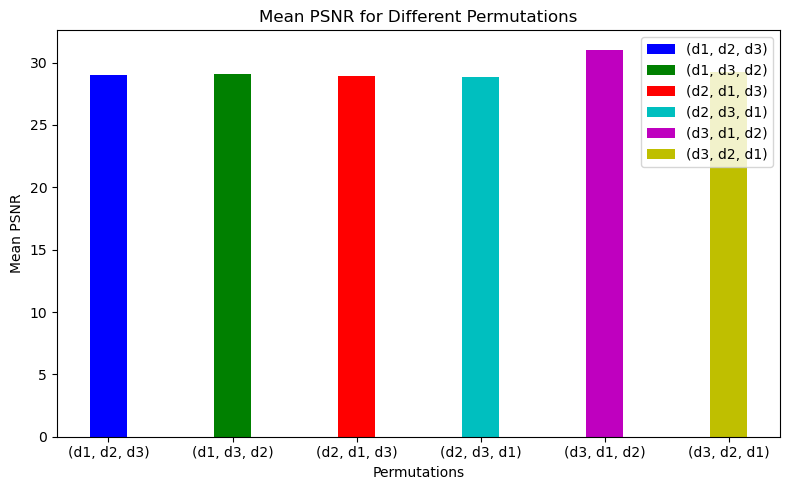

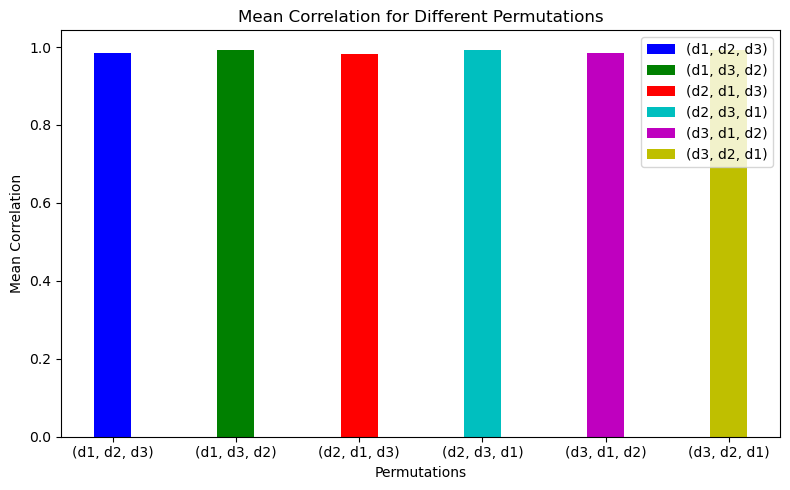

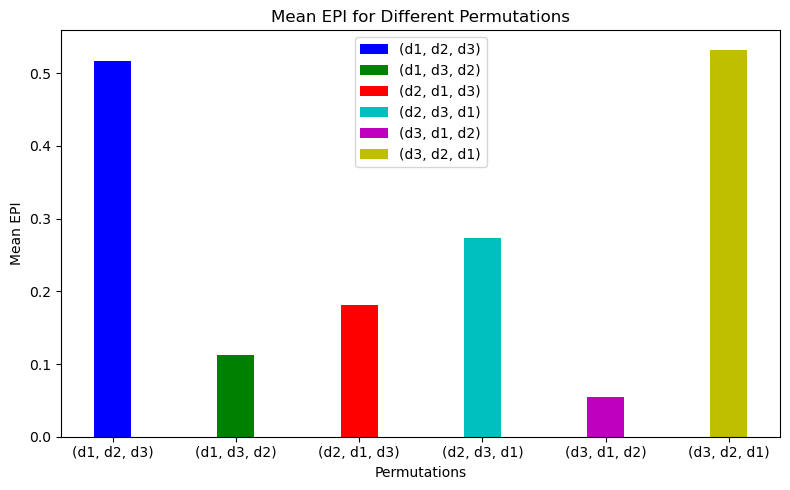

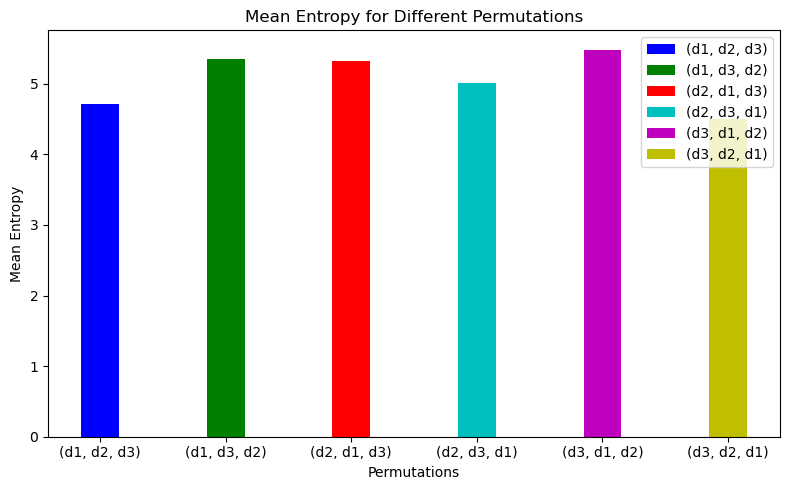

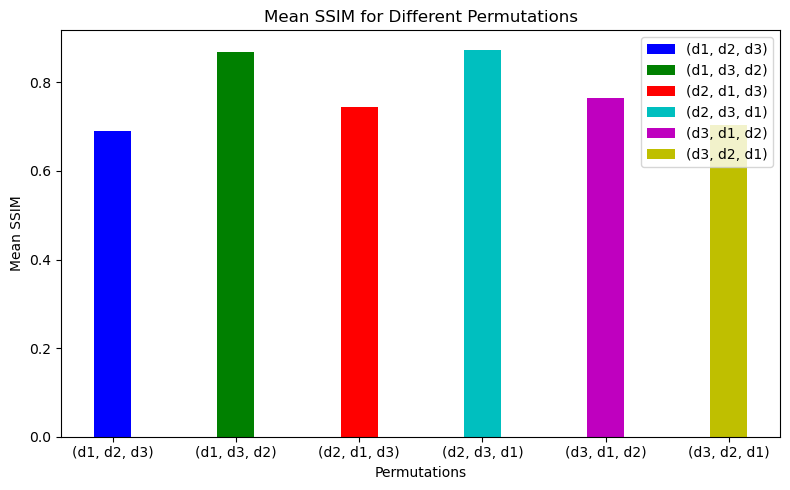

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for each permutation
permutation_labels = [
    '(d1, d2, d3)',
    '(d1, d3, d2)',
    '(d2, d1, d3)',
    '(d2, d3, d1)',
    '(d3, d1, d2)',
    '(d3, d2, d1)'
]

metrics = [mean_psnr, mean_correlation, mean_epi, mean_entropy, mean_ssim]
metric_names = ['Mean PSNR', 'Mean Correlation', 'Mean EPI', 'Mean Entropy', 'Mean SSIM']

colors = ['b', 'g', 'r', 'c', 'm', 'y']

num_permutations = len(permutation_labels)
bar_width = 0.30
index = np.arange(num_permutations)

for metric, metric_name in zip(metrics, metric_names):
    plt.figure(figsize=(8, 5))
    
    for i in range(len(metric)):
        plt.bar(index[i], metric[i], bar_width, color=colors[i], label=permutation_labels[i])
    
    plt.xlabel('Permutations')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Different Permutations')
    plt.xticks(index, permutation_labels)
    plt.legend()
    plt.tight_layout()
    plt.show()


## e_Ophtha

In [9]:
psnr_list=[]
correlation_list=[]
epi_list=[]
entropy_list=[]
ssim_list=[]

for i in range(len(paths.images['e_ophtha'][:47])):
        img = cv2.imread(paths.images['e_ophtha'][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        psnr_scores, correlation_scores, epi_scores, entropy_scores, ssim_scores = preprocess(img)
    
        psnr_list.append(psnr_scores)
        correlation_list.append(correlation_scores)
        epi_list.append(epi_scores)
        entropy_list.append(entropy_scores)
        ssim_list.append(ssim_scores)

In [10]:
psnr_arr = np.array(psnr_list)
mean_psnr = np.mean(psnr_arr, axis=0)

correlation_arr = np.array(correlation_list)
mean_correlation = np.mean(correlation_arr, axis=0)

epi_arr = np.array(epi_list)
mean_epi = np.mean(epi_arr, axis=0)

entropy_arr = np.array(entropy_list)
mean_entropy = np.mean(entropy_arr, axis=0)

ssim_arr = np.array(ssim_list)
mean_ssim = np.mean(ssim_arr, axis=0)

print("Mean PSNR:", mean_psnr)
print("Mean Correlation:", mean_correlation)
print("Mean EPI:", mean_epi)
print("Mean Entropy:", mean_entropy)
print("Mean SSIM:", mean_ssim)

Mean PSNR: [29.86095354 33.25393847 31.23202535 30.02581848 30.80443121 29.94407857]
Mean Correlation: [0.98493647 0.9909973  0.98311826 0.99282532 0.98607652 0.99153969]
Mean EPI: [ 0.4163692  -0.00249158  0.01898252  0.18354141 -0.11967444  0.44271153]
Mean Entropy: [4.11750722 4.66968903 4.65064266 4.29818689 4.81219745 3.85690657]
Mean SSIM: [0.7300988  0.81795768 0.6760131  0.89386644 0.67158082 0.77684231]


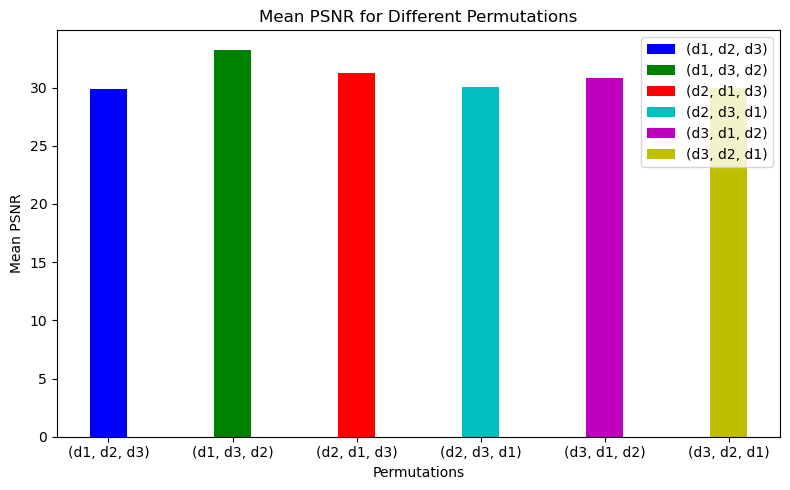

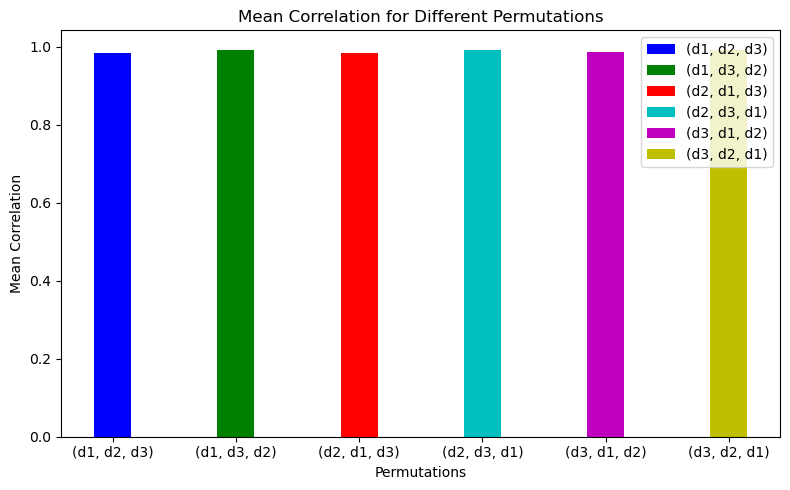

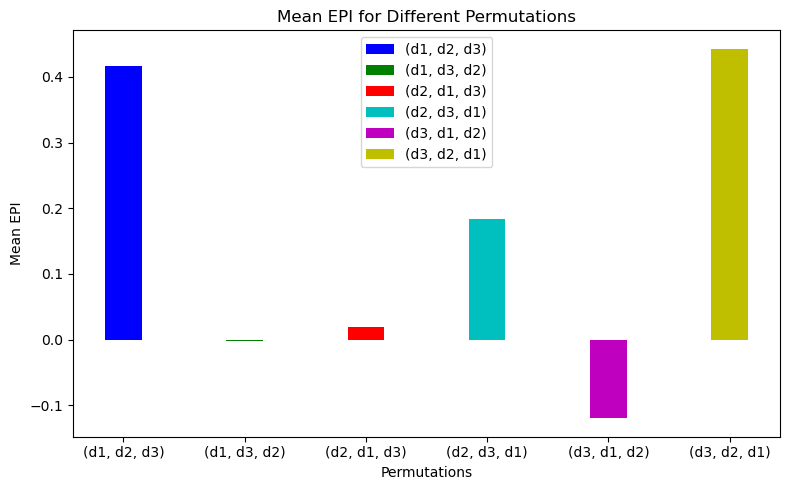

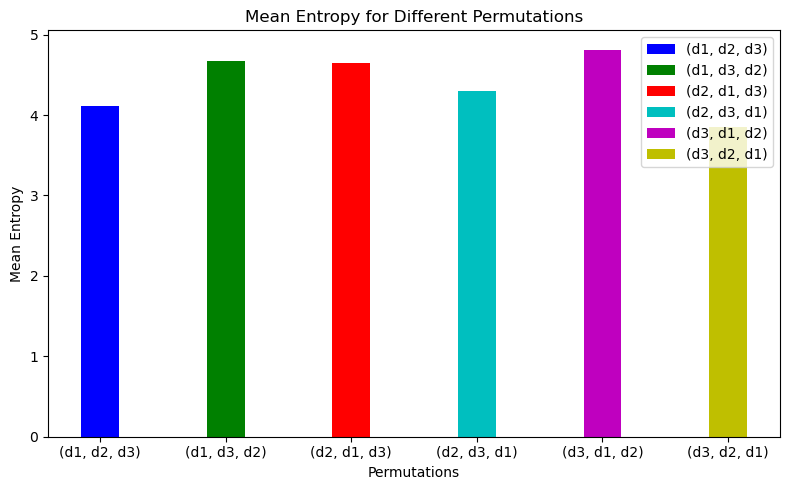

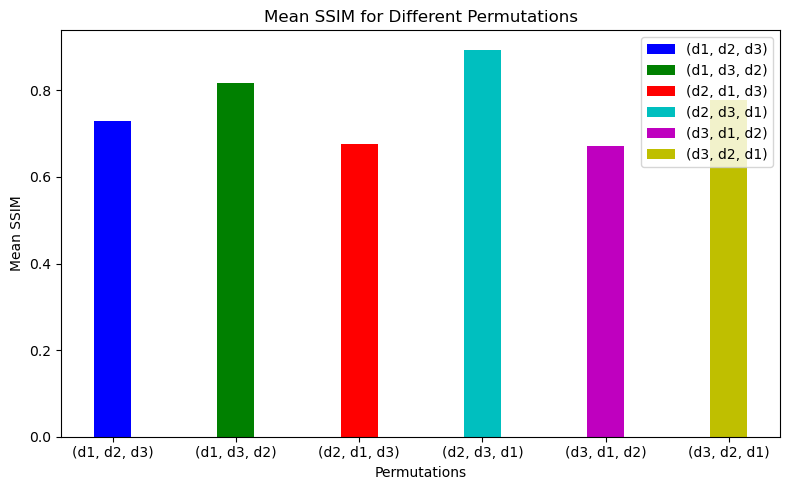

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for each permutation
permutation_labels = [
    '(d1, d2, d3)',
    '(d1, d3, d2)',
    '(d2, d1, d3)',
    '(d2, d3, d1)',
    '(d3, d1, d2)',
    '(d3, d2, d1)'
]

metrics = [mean_psnr, mean_correlation, mean_epi, mean_entropy, mean_ssim]
metric_names = ['Mean PSNR', 'Mean Correlation', 'Mean EPI', 'Mean Entropy', 'Mean SSIM']

colors = ['b', 'g', 'r', 'c', 'm', 'y']

num_permutations = len(permutation_labels)
bar_width = 0.30
index = np.arange(num_permutations)

for metric, metric_name in zip(metrics, metric_names):
    plt.figure(figsize=(8, 5))
    
    for i in range(len(metric)):
        plt.bar(index[i], metric[i], bar_width, color=colors[i], label=permutation_labels[i])
    
    plt.xlabel('Permutations')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Different Permutations')
    plt.xticks(index, permutation_labels)
    plt.legend()
    plt.tight_layout()
    plt.show()

# classes


In [1]:
from SSIM import recombination_analysis

C:\Users\DELL\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Mean PSNR: [28.9779956  29.0969444  29.08415379 28.80043028 30.75780764 28.95927225]
Mean Correlation: [0.9808376  0.98967662 0.97750659 0.99103233 0.98267824 0.99013522]
Mean EPI: [ 0.46952079  0.06398954  0.09559064  0.24859426 -0.03291446  0.50571404]
Mean Entropy: [5.16599999 5.80443032 5.79294363 5.42683599 5.99258436 4.86712096]
Mean SSIM: [0.73739892 0.9014548  0.80482328 0.87872995 0.82058155 0.70643705]


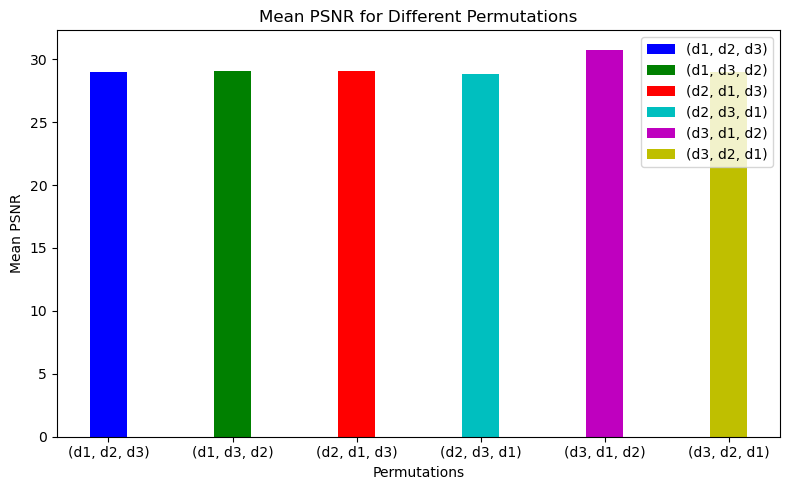

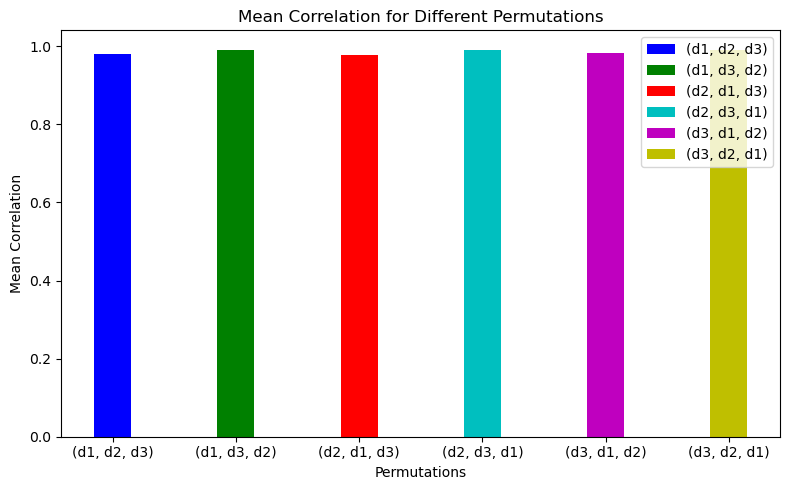

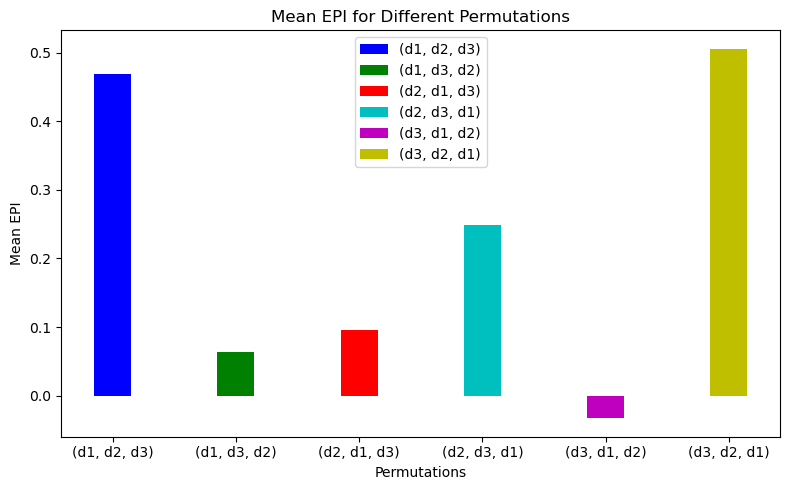

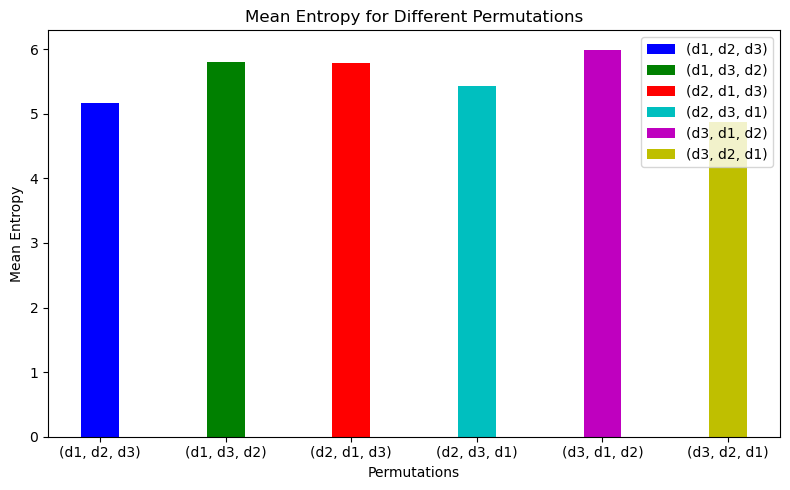

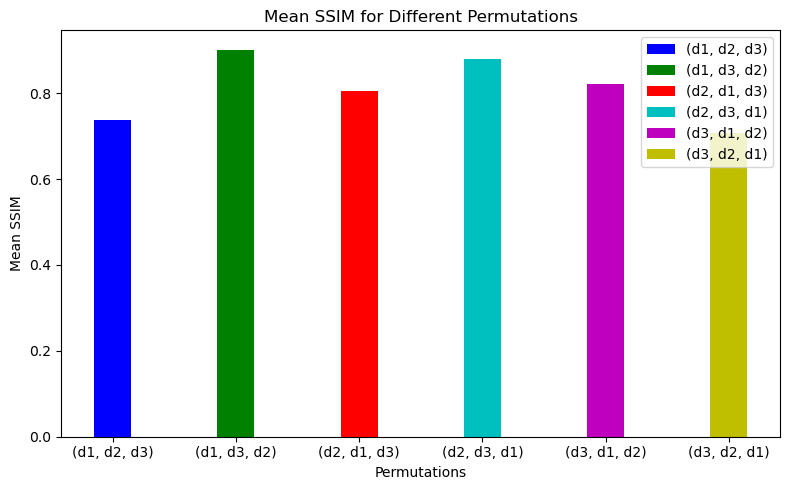

In [2]:
obj_1 = recombination_analysis('idrid')
obj_1.run_experiment()

In [ ]:
obj_2 = recombination_analysis('e_ophtha')
obj_2.run_experiment()

In [7]:
def edge_preservation_index(ref_image, processed_image):
        numerator_sum = np.sum(np.abs(processed_image[:, 1:] - processed_image[:, :-1]))
        denominator_sum = np.sum(np.abs(ref_image[:, 1:] - ref_image[:, :-1]))
        epi = numerator_sum/denominator_sum
        
        return epi

In [8]:
def calculate_psnr(original_img, processed_img):
    mse = np.mean((original_img - processed_img) ** 2)
    max_pixel_value = 255.0
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr

def calculate_correlation(original_img, processed_img):
    original_flat = original_img.flatten()
    processed_flat = processed_img.flatten()
    correlation = np.corrcoef(original_flat, processed_flat)[0, 1]
    return correlation

# def edge_preservation_index(ref_image, processed_image):
    
#     # Compute gradient magnitude images
#     ref_grad = cv2.Laplacian(ref_image, cv2.CV_64F)
#     processed_grad = cv2.Laplacian(processed_image, cv2.CV_64F)
    
#     # Calculate the edge preservation index
#     epi = np.sum(np.abs(ref_grad) - np.abs(processed_grad)) / np.sum(np.abs(ref_grad))
    
#     return epi

def calculate_entropy(image):
    
    flattened_image = image.flatten()
    histogram = np.histogram(flattened_image, bins=256, range=(0, 255))[0]
    histogram = histogram / float(np.sum(histogram))
    histogram = histogram[np.nonzero(histogram)]
    entropy = -np.sum(histogram * np.log2(histogram))

    return entropy

def calculate_ssim(reference_img, processed_img):
    
    ssim_score = ssim(reference_img, processed_img)
    
    return ssim_score
    
    

def preprocess(img):
    
        img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # 1. Gaussian filter ---> CLAHE --->  Unsharp-Mask
        gaus_img = cv2.GaussianBlur(img_gray , (5,5) , 0 , borderType = cv2.BORDER_CONSTANT)
        hist_equ = exposure.equalize_adapthist(gaus_img)
        unsharp_bilat = unsharp_mask(hist_equ , radius=7 , amount=2 )

        # 2. Split channels ---> Median Blur 2x ---> CLAHE --->  Gamma filter
        r,g,b = cv2.split(img)
        img_med = cv2.medianBlur(g,3)
        img_med_1 = cv2.medianBlur(img_med,3)
        clahe = cv2.createCLAHE(clipLimit=2,tileGridSize= (8,8))
        cl_img = clahe.apply(img_med_1)
        gamma_img = np.array(255*(cl_img/255)**0.8,dtype='uint8')


        #Merging the 3 pre-processed imgs
        l,m = gamma_img.shape
        final_img=np.ones((l,m,3))
        final_img[:,:,0]=final_img[:,:,0]*gamma_img
        final_img[:,:,1]=final_img[:,:,1]*unsharp_bilat
        final_img[:,:,2]=final_img[:,:,2]*g


        d1,d2,d3 = cv2.split(final_img)

        permutations = [
                            cv2.cvtColor(cv2.merge((d1, d2, d3)).astype(np.uint8), cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(cv2.merge((d1, d3, d2)).astype(np.uint8), cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(cv2.merge((d2, d1, d3)).astype(np.uint8), cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(cv2.merge((d2, d3, d1)).astype(np.uint8), cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(cv2.merge((d3, d1, d2)).astype(np.uint8), cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(cv2.merge((d3, d2, d1)).astype(np.uint8), cv2.COLOR_RGB2GRAY)
                        ]
        

        
        psnr_list = [calculate_psnr(img_gray, perm) for perm in permutations]
        correlation_list = [calculate_correlation(img_gray, perm) for perm in permutations]
        epi_list = [edge_preservation_index(img_gray, perm) for perm in permutations]
        entropy_list = [calculate_entropy(perm) for perm in permutations]
        ssim_list = [calculate_ssim(img_gray, perm) for perm in permutations]

 
            
        return psnr_list, correlation_list, epi_list, entropy_list, ssim_list

In [9]:
psnr_list=[]
correlation_list=[]
epi_list=[]
entropy_list=[]
ssim_list=[]

for i in range(len(paths.images['idrid'][:54])):
        img = cv2.imread(paths.images['idrid'][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        psnr_scores, correlation_scores, epi_scores, entropy_scores, ssim_scores = preprocess(img)
    
        psnr_list.append(psnr_scores)
        correlation_list.append(correlation_scores)
        epi_list.append(epi_scores)
        entropy_list.append(entropy_scores)
        ssim_list.append(ssim_scores)

In [10]:
psnr_arr = np.array(psnr_list)
mean_psnr = np.mean(psnr_arr, axis=0)

correlation_arr = np.array(correlation_list)
mean_correlation = np.mean(correlation_arr, axis=0)

epi_arr = np.array(epi_list)
mean_epi = np.mean(epi_arr, axis=0)

entropy_arr = np.array(entropy_list)
mean_entropy = np.mean(entropy_arr, axis=0)

ssim_arr = np.array(ssim_list)
mean_ssim = np.mean(ssim_arr, axis=0)

print("Mean PSNR:", mean_psnr)
print("Mean Correlation:", mean_correlation)
print("Mean EPI:", mean_epi)
print("Mean Entropy:", mean_entropy)
print("Mean SSIM:", mean_ssim)

Mean PSNR: [29.00733382 29.11351412 28.96085698 28.84534162 31.03674915 29.2144034 ]
Mean Correlation: [0.98420007 0.99158925 0.98151261 0.99317894 0.98561849 0.99211866]
Mean EPI: [0.72380041 0.97573684 0.79728338 0.91663691 0.91118054 0.73747194]
Mean Entropy: [4.71903878 5.35362069 5.3261476  5.01562925 5.48336074 4.50815838]
Mean SSIM: [0.69078041 0.86765524 0.74402434 0.87381167 0.76437846 0.70333971]


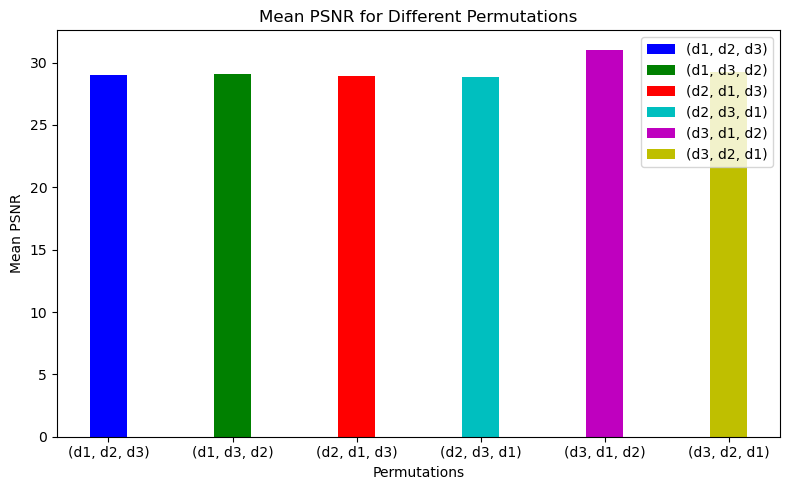

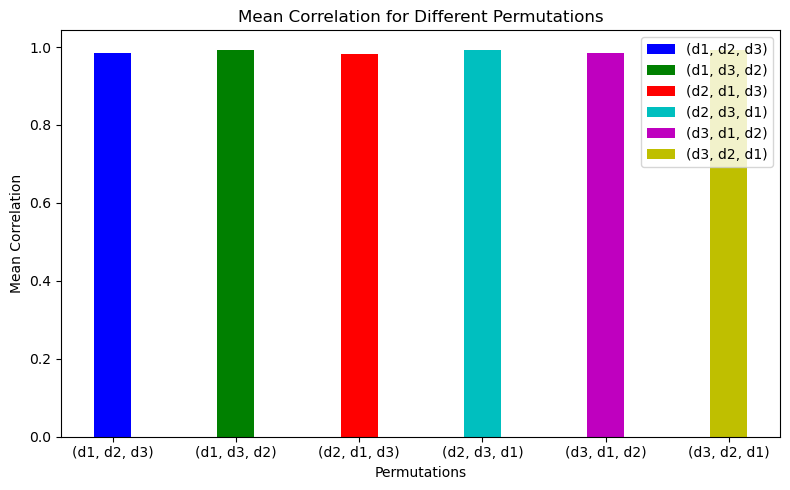

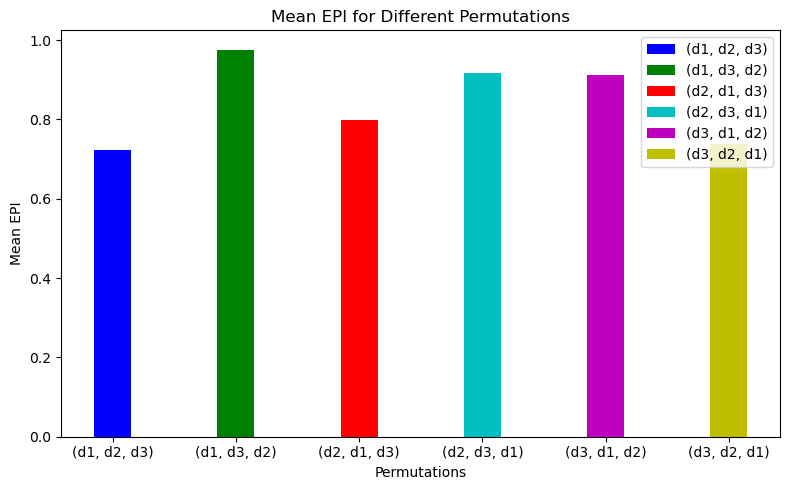

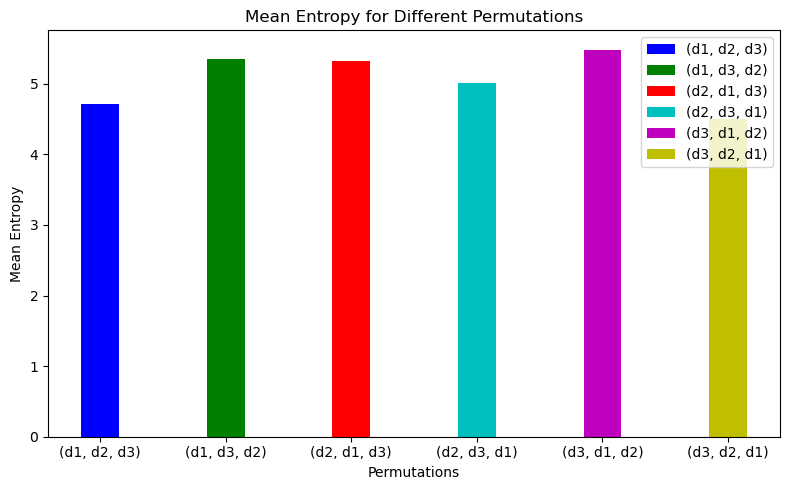

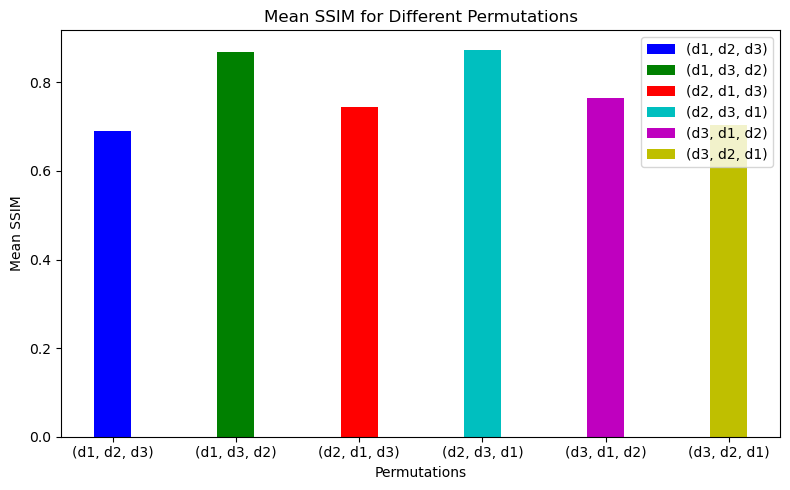

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for each permutation
permutation_labels = [
    '(d1, d2, d3)',
    '(d1, d3, d2)',
    '(d2, d1, d3)',
    '(d2, d3, d1)',
    '(d3, d1, d2)',
    '(d3, d2, d1)'
]

metrics = [mean_psnr, mean_correlation, mean_epi, mean_entropy, mean_ssim]
metric_names = ['Mean PSNR', 'Mean Correlation', 'Mean EPI', 'Mean Entropy', 'Mean SSIM']

colors = ['b', 'g', 'r', 'c', 'm', 'y']

num_permutations = len(permutation_labels)
bar_width = 0.30
index = np.arange(num_permutations)

for metric, metric_name in zip(metrics, metric_names):
    plt.figure(figsize=(8, 5))
    
    for i in range(len(metric)):
        plt.bar(index[i], metric[i], bar_width, color=colors[i], label=permutation_labels[i])
    
    plt.xlabel('Permutations')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Different Permutations')
    plt.xticks(index, permutation_labels)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Gaussian noise addition

Mean PSNR: [29.00733382 29.11351412 28.96085698 28.84534162 31.03674915 29.2144034 ]
Mean Correlation: [0.98420007 0.99158925 0.98151261 0.99317894 0.98561849 0.99211866]
Mean EPI: [0.72380041 0.97573684 0.79728338 0.91663691 0.91118054 0.73747194]
Mean Entropy: [4.71903878 5.35362069 5.3261476  5.01562925 5.48336074 4.50815838]
Mean SSIM: [0.69078041 0.86765524 0.74402434 0.87381167 0.76437846 0.70333971]


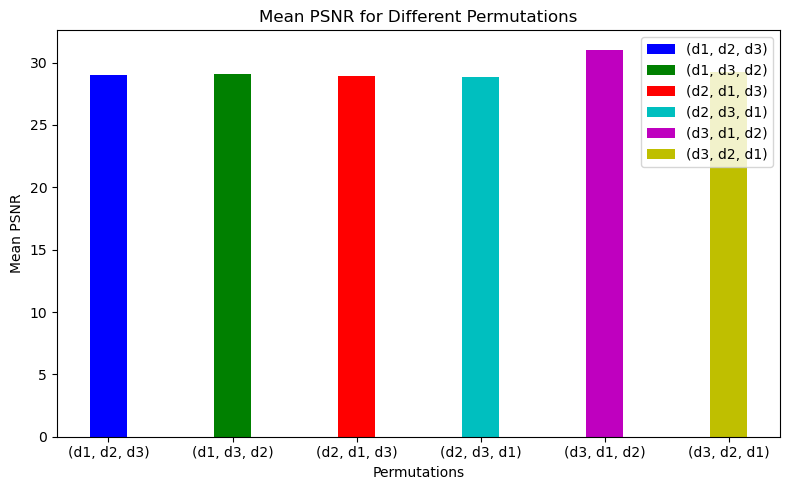

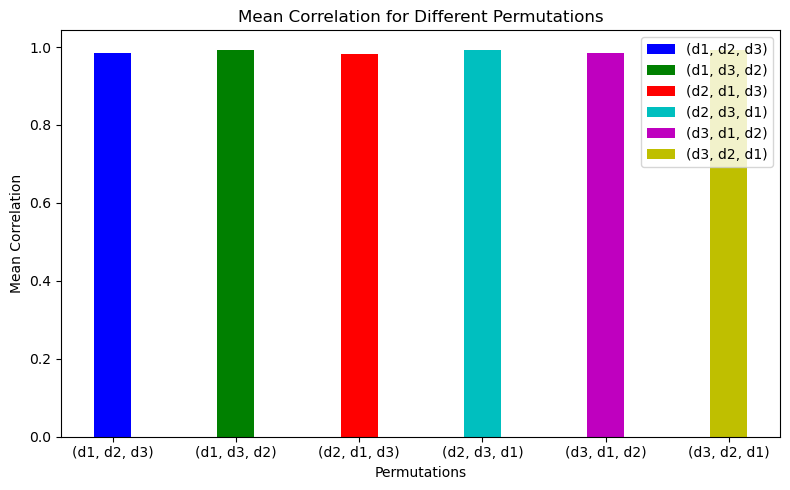

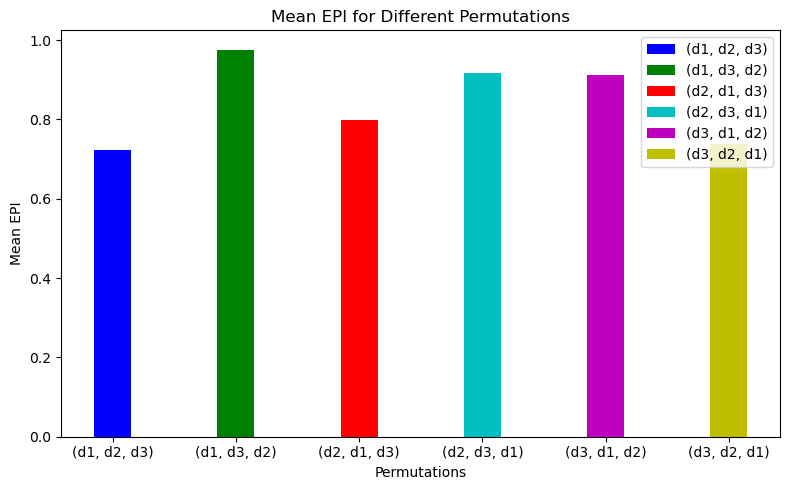

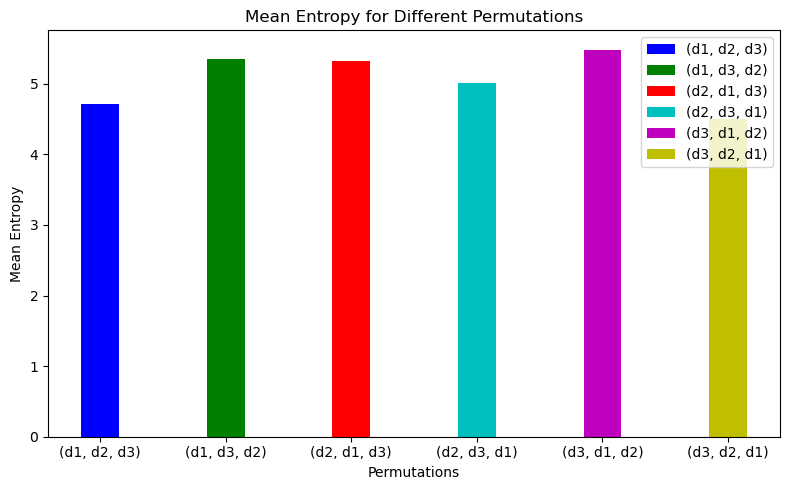

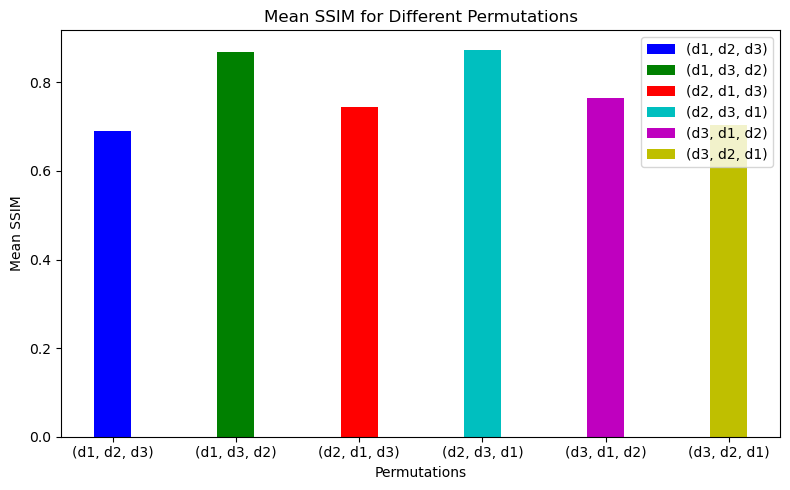

In [12]:
mean = 0
variance = 0.001
stddev = np.sqrt(variance)

psnr_list=[]
correlation_list=[]
epi_list=[]
entropy_list=[]
ssim_list=[]

for i in range(len(paths.images['idrid'][:54])):
        img = cv2.imread(paths.images['idrid'][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gaussian_noise = np.random.normal(mean, stddev, img.shape).astype(np.uint8)
        img = cv2.add(img, gaussian_noise)
        psnr_scores, correlation_scores, epi_scores, entropy_scores, ssim_scores = preprocess(img)
    
        psnr_list.append(psnr_scores)
        correlation_list.append(correlation_scores)
        epi_list.append(epi_scores)
        entropy_list.append(entropy_scores)
        ssim_list.append(ssim_scores)
        
        
        
psnr_arr = np.array(psnr_list)
mean_psnr = np.mean(psnr_arr, axis=0)

correlation_arr = np.array(correlation_list)
mean_correlation = np.mean(correlation_arr, axis=0)

epi_arr = np.array(epi_list)
mean_epi = np.mean(epi_arr, axis=0)

entropy_arr = np.array(entropy_list)
mean_entropy = np.mean(entropy_arr, axis=0)

ssim_arr = np.array(ssim_list)
mean_ssim = np.mean(ssim_arr, axis=0)

print("Mean PSNR:", mean_psnr)
print("Mean Correlation:", mean_correlation)
print("Mean EPI:", mean_epi)
print("Mean Entropy:", mean_entropy)
print("Mean SSIM:", mean_ssim)



# Labels for each permutation
permutation_labels = [
    '(d1, d2, d3)',
    '(d1, d3, d2)',
    '(d2, d1, d3)',
    '(d2, d3, d1)',
    '(d3, d1, d2)',
    '(d3, d2, d1)'
]

metrics = [mean_psnr, mean_correlation, mean_epi, mean_entropy, mean_ssim]
metric_names = ['Mean PSNR', 'Mean Correlation', 'Mean EPI', 'Mean Entropy', 'Mean SSIM']

colors = ['b', 'g', 'r', 'c', 'm', 'y']

num_permutations = len(permutation_labels)
bar_width = 0.30
index = np.arange(num_permutations)

for metric, metric_name in zip(metrics, metric_names):
    plt.figure(figsize=(8, 5))
    
    for i in range(len(metric)):
        plt.bar(index[i], metric[i], bar_width, color=colors[i], label=permutation_labels[i])
    
    plt.xlabel('Permutations')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Different Permutations')
    plt.xticks(index, permutation_labels)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
mean = 0
variance = 0.01
stddev = np.sqrt(variance)

psnr_list=[]
correlation_list=[]
epi_list=[]
entropy_list=[]
ssim_list=[]

for i in range(len(paths.images['idrid'][:54])):
        img = cv2.imread(paths.images['idrid'][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gaussian_noise = np.random.normal(mean, stddev, img.shape).astype(np.uint8)
        img = cv2.add(img, gaussian_noise)
        psnr_scores, correlation_scores, epi_scores, entropy_scores, ssim_scores = preprocess(img)
    
        psnr_list.append(psnr_scores)
        correlation_list.append(correlation_scores)
        epi_list.append(epi_scores)
        entropy_list.append(entropy_scores)
        ssim_list.append(ssim_scores)
        
        
        
psnr_arr = np.array(psnr_list)
mean_psnr = np.mean(psnr_arr, axis=0)

correlation_arr = np.array(correlation_list)
mean_correlation = np.mean(correlation_arr, axis=0)

epi_arr = np.array(epi_list)
mean_epi = np.mean(epi_arr, axis=0)

entropy_arr = np.array(entropy_list)
mean_entropy = np.mean(entropy_arr, axis=0)

ssim_arr = np.array(ssim_list)
mean_ssim = np.mean(ssim_arr, axis=0)

print("Mean PSNR:", mean_psnr)
print("Mean Correlation:", mean_correlation)
print("Mean EPI:", mean_epi)
print("Mean Entropy:", mean_entropy)
print("Mean SSIM:", mean_ssim)



# Labels for each permutation
permutation_labels = [
    '(d1, d2, d3)',
    '(d1, d3, d2)',
    '(d2, d1, d3)',
    '(d2, d3, d1)',
    '(d3, d1, d2)',
    '(d3, d2, d1)'
]

metrics = [mean_psnr, mean_correlation, mean_epi, mean_entropy, mean_ssim]
metric_names = ['Mean PSNR', 'Mean Correlation', 'Mean EPI', 'Mean Entropy', 'Mean SSIM']

colors = ['b', 'g', 'r', 'c', 'm', 'y']

num_permutations = len(permutation_labels)
bar_width = 0.30
index = np.arange(num_permutations)

for metric, metric_name in zip(metrics, metric_names):
    plt.figure(figsize=(8, 5))
    
    for i in range(len(metric)):
        plt.bar(index[i], metric[i], bar_width, color=colors[i], label=permutation_labels[i])
    
    plt.xlabel('Permutations')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Different Permutations')
    plt.xticks(index, permutation_labels)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
mean = 0
variance = 0.1
stddev = np.sqrt(variance)

psnr_list=[]
correlation_list=[]
epi_list=[]
entropy_list=[]
ssim_list=[]

for i in range(len(paths.images['idrid'][:54])):
        img = cv2.imread(paths.images['idrid'][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gaussian_noise = np.random.normal(mean, stddev, img.shape).astype(np.uint8)
        img = cv2.add(img, gaussian_noise)
        psnr_scores, correlation_scores, epi_scores, entropy_scores, ssim_scores = preprocess(img)
    
        psnr_list.append(psnr_scores)
        correlation_list.append(correlation_scores)
        epi_list.append(epi_scores)
        entropy_list.append(entropy_scores)
        ssim_list.append(ssim_scores)
        
        
        
psnr_arr = np.array(psnr_list)
mean_psnr = np.mean(psnr_arr, axis=0)

correlation_arr = np.array(correlation_list)
mean_correlation = np.mean(correlation_arr, axis=0)

epi_arr = np.array(epi_list)
mean_epi = np.mean(epi_arr, axis=0)

entropy_arr = np.array(entropy_list)
mean_entropy = np.mean(entropy_arr, axis=0)

ssim_arr = np.array(ssim_list)
mean_ssim = np.mean(ssim_arr, axis=0)

print("Mean PSNR:", mean_psnr)
print("Mean Correlation:", mean_correlation)
print("Mean EPI:", mean_epi)
print("Mean Entropy:", mean_entropy)
print("Mean SSIM:", mean_ssim)



# Labels for each permutation
permutation_labels = [
    '(d1, d2, d3)',
    '(d1, d3, d2)',
    '(d2, d1, d3)',
    '(d2, d3, d1)',
    '(d3, d1, d2)',
    '(d3, d2, d1)'
]

metrics = [mean_psnr, mean_correlation, mean_epi, mean_entropy, mean_ssim]
metric_names = ['Mean PSNR', 'Mean Correlation', 'Mean EPI', 'Mean Entropy', 'Mean SSIM']

colors = ['b', 'g', 'r', 'c', 'm', 'y']

num_permutations = len(permutation_labels)
bar_width = 0.30
index = np.arange(num_permutations)

for metric, metric_name in zip(metrics, metric_names):
    plt.figure(figsize=(8, 5))
    
    for i in range(len(metric)):
        plt.bar(index[i], metric[i], bar_width, color=colors[i], label=permutation_labels[i])
    
    plt.xlabel('Permutations')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Different Permutations')
    plt.xticks(index, permutation_labels)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
mean = 0
variance = 0.2
stddev = np.sqrt(variance)

psnr_list=[]
correlation_list=[]
epi_list=[]
entropy_list=[]
ssim_list=[]

for i in range(len(paths.images['idrid'][:54])):
        img = cv2.imread(paths.images['idrid'][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gaussian_noise = np.random.normal(mean, stddev, img.shape).astype(np.uint8)
        img = cv2.add(img, gaussian_noise)
        psnr_scores, correlation_scores, epi_scores, entropy_scores, ssim_scores = preprocess(img)
    
        psnr_list.append(psnr_scores)
        correlation_list.append(correlation_scores)
        epi_list.append(epi_scores)
        entropy_list.append(entropy_scores)
        ssim_list.append(ssim_scores)
        
        
        
psnr_arr = np.array(psnr_list)
mean_psnr = np.mean(psnr_arr, axis=0)

correlation_arr = np.array(correlation_list)
mean_correlation = np.mean(correlation_arr, axis=0)

epi_arr = np.array(epi_list)
mean_epi = np.mean(epi_arr, axis=0)

entropy_arr = np.array(entropy_list)
mean_entropy = np.mean(entropy_arr, axis=0)

ssim_arr = np.array(ssim_list)
mean_ssim = np.mean(ssim_arr, axis=0)

print("Mean PSNR:", mean_psnr)
print("Mean Correlation:", mean_correlation)
print("Mean EPI:", mean_epi)
print("Mean Entropy:", mean_entropy)
print("Mean SSIM:", mean_ssim)



# Labels for each permutation
permutation_labels = [
    '(d1, d2, d3)',
    '(d1, d3, d2)',
    '(d2, d1, d3)',
    '(d2, d3, d1)',
    '(d3, d1, d2)',
    '(d3, d2, d1)'
]

metrics = [mean_psnr, mean_correlation, mean_epi, mean_entropy, mean_ssim]
metric_names = ['Mean PSNR', 'Mean Correlation', 'Mean EPI', 'Mean Entropy', 'Mean SSIM']

colors = ['b', 'g', 'r', 'c', 'm', 'y']

num_permutations = len(permutation_labels)
bar_width = 0.30
index = np.arange(num_permutations)

for metric, metric_name in zip(metrics, metric_names):
    plt.figure(figsize=(8, 5))
    
    for i in range(len(metric)):
        plt.bar(index[i], metric[i], bar_width, color=colors[i], label=permutation_labels[i])
    
    plt.xlabel('Permutations')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Different Permutations')
    plt.xticks(index, permutation_labels)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def run_experiment(self, mean, variance):
    
            stddev = np.sqrt(variance)
        
            psnr_list=[]
            correlation_list=[]
            epi_list=[]
            entropy_list=[]
            ssim_list=[]

            for i in range(len(self.paths.images[self.data][:self.num])):
                    img = cv2.imread(self.paths.images[self.data][i])
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    gaussian_noise = np.random.normal(mean, stddev, img.shape).astype(np.uint8)
                    img = cv2.add(img, gaussian_noise)
                    psnr_scores, correlation_scores, epi_scores, entropy_scores, ssim_scores = self.process(img)

                    psnr_list.append(psnr_scores)
                    correlation_list.append(correlation_scores)
                    epi_list.append(epi_scores)
                    entropy_list.append(entropy_scores)
                    ssim_list.append(ssim_scores)

            self.psnr_arr = np.array(psnr_list)
            self.mean_psnr = np.mean(self.psnr_arr, axis=0)

            self.correlation_arr = np.array(correlation_list)
            self.mean_correlation = np.mean(self.correlation_arr, axis=0)

            self.epi_arr = np.array(epi_list)
            self.mean_epi = np.mean(self.epi_arr, axis=0)

            self.entropy_arr = np.array(entropy_list)
            self.mean_entropy = np.mean(self.entropy_arr, axis=0)

            self.ssim_arr = np.array(ssim_list)
            self.mean_ssim = np.mean(self.ssim_arr, axis=0)

            print("Mean PSNR:", self.mean_psnr)
            print("Mean Correlation:", self.mean_correlation)
            print("Mean EPI:", self.mean_epi)
            print("Mean Entropy:", self.mean_entropy)
            print("Mean SSIM:", self.mean_ssim)

            # Labels for each permutation
            permutation_labels = [
                '(d1, d2, d3)',
                '(d1, d3, d2)',
                '(d2, d1, d3)',
                '(d2, d3, d1)',
                '(d3, d1, d2)',
                '(d3, d2, d1)'
            ]

            metrics = [self.mean_psnr, self.mean_correlation, self.mean_epi, self.mean_entropy, self.mean_ssim]
            metric_names = ['Mean PSNR', 'Mean Correlation', 'Mean EPI', 'Mean Entropy', 'Mean SSIM']

            colors = ['b', 'g', 'r', 'c', 'm', 'y']

            num_permutations = len(permutation_labels)
            bar_width = 0.30
            index = np.arange(num_permutations)

            for metric, metric_name in zip(metrics, metric_names):
                plt.figure(figsize=(8, 5))

                for i in range(len(metric)):
                    plt.bar(index[i], metric[i], bar_width, color=colors[i], label=permutation_labels[i])

                plt.xlabel('Permutations')
                plt.ylabel(metric_name)
                plt.title(f'{metric_name} for Different Permutations')
                plt.xticks(index, permutation_labels)
                plt.legend()
                plt.tight_layout()
                plt.show()

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt

def add_salt_and_pepper_noise(image, noise_variance):
    noisy_image = np.copy(image)
    
    # Generate random values for noise
    noise = np.random.normal(0, np.sqrt(noise_variance), image.shape)
    
    # Add noise to the image
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    
    return noisy_image

# Load an image
image = cv2.imread(paths.images['idrid'][0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Define the noise variance
noise_variance = 50

# Add salt and pepper noise
noisy_image = add_salt_and_pepper_noise(image, noise_variance)

plt.figure()
# Display the original and noisy images
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')

plt.show()


mean = 0
variance = 50
stddev = np.sqrt(variance)

img = cv2.imread(paths.images['idrid'][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gaussian_noise = np.random.normal(mean , stddev , img.shape).astype(np.uint8)
img_noise = cv2.add(img, gaussian_noise)

plt.figure()

# Display the original and noisy images
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img_noise, cmap='gray')
plt.title('Noisy Image')

plt.show()

In [26]:
def add_salt_and_pepper_noise(image, noise_variance):
    noisy_image = np.copy(image)
    
    # Generate random values for noise
    noise = np.random.normal(0, noise_variance, image.shape)
    
    # Add noise to the image
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    
    return noisy_image

In [27]:
img = np.ones((1024,1024))

In [30]:
# Add salt and pepper noise
noisy_image = add_salt_and_pepper_noise(img, 100)

In [31]:
plt.imshow(noisy_image)

In [33]:

mean = 0
variance = 50
stddev = np.sqrt(variance)
gaussian_noise = np.random.normal(mean , stddev , img.shape).astype(np.uint8)
img_noise = np.add(img, gaussian_noise)

plt.imshow(img_noise)


In [22]:
import numpy as np

# Create a 256x256 array of zeros
array = np.zeros((img.shape[0],img.shape[1]))

# Calculate the number of values to replace (1% of total)
num_values_to_replace = int(0.01 * array.size)

# Generate random indices for the positions to replace
replace_indices = np.random.choice(array.size, num_values_to_replace * 2, replace=False)

# Shuffle the indices to ensure randomness
np.random.shuffle(replace_indices)

# Replace the selected values with -500 and +500
for i in range(num_values_to_replace):
    index = replace_indices[i]
    row, col = divmod(index, array.shape[1])  # Convert 1D index to 2D indices
    array[row, col] = -500

for i in range(num_values_to_replace):
    index = replace_indices[num_values_to_replace + i]
    row, col = divmod(index, array.shape[1])  # Convert 1D index to 2D indices
    array[row, col] = 500

# Print the resulting array
print(array)
plt.imshow(array)

[[ 128.  128.  128. ...  128.  128.  128.]
 [ 128.  128.  128. ...  500.  128.  128.]
 [ 128.  128.  128. ...  128.  128.  128.]
 ...
 [ 128.  128.  128. ...  128.  128. -500.]
 [ 128.  128.  128. ...  128.  128.  128.]
 [ 128.  128.  128. ...  128.  128.  128.]]


In [23]:
np.unique(array)

array([-500.,  128.,  500.])

In [24]:
x = np.clip(array, 0, 255).astype(np.uint8)
np.unique(x)

array([  0, 128, 255], dtype=uint8)

In [25]:
plt.imshow(x)

In [38]:
import numpy as np

def salt_pepper_noise(img, percent):
        # Create a 256x256 array of zeros
        array = np.zeros((img.shape[0],img.shape[1]))

        # Calculate the number of values to replace (1% of total)
        num_values_to_replace = int(percent * array.size)

        # Generate random indices for the positions to replace
        replace_indices = np.random.choice(array.size, num_values_to_replace * 2, replace=False)

        # Shuffle the indices to ensure randomness
        np.random.shuffle(replace_indices)

        # Replace the selected values with -500 and +500
        for i in range(num_values_to_replace):
            index = replace_indices[i]
            row, col = divmod(index, array.shape[1])  # Convert 1D index to 2D indices
            array[row, col] = -500

        for i in range(num_values_to_replace):
            index = replace_indices[num_values_to_replace + i]
            row, col = divmod(index, array.shape[1])  # Convert 1D index to 2D indices
            array[row, col] = 500

        return array

In [52]:
image = cv2.imread(paths.images['idrid'][0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

noise = salt_pepper_noise(image,0.2)
noise = np.expand_dims(noise, axis=-1)
noisy = np.clip(image + noise, 0, 255).astype(np.uint8)


plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(noisy, cmap='gray')
plt.title('Noisy Image')

plt.show()

(2848, 4288, 3) (2848, 4288)
[-500.    0.  500.]


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def salt_pepper_noise(img, percent):
    # Create a copy of the input image
    noisy_image = np.copy(img)

    # Calculate the number of values to replace (1% of total)
    num_values_to_replace = int(percent * noisy_image.size)

    # Generate random indices for the positions to replace
    replace_indices = np.random.choice(noisy_image.size, num_values_to_replace * 2, replace=False)

    # Shuffle the indices to ensure randomness
    np.random.shuffle(replace_indices)

    # Replace the selected values with -500 and +500
    for i in range(num_values_to_replace):
        index = replace_indices[i]
        row, col = divmod(index, noisy_image.shape[1])  # Convert 1D index to 2D indices
        noisy_image[row, col] = -500

    for i in range(num_values_to_replace):
        index = replace_indices[num_values_to_replace + i]
        row, col = divmod(index, noisy_image.shape[1])  # Convert 1D index to 2D indices
        noisy_image[row, col] = 500

    return noisy_image

# image_path = 'path/to/your/image.jpg'
# image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

noise_percent = 0.02  # 2% noise
noisy_image = salt_pepper_noise(image, noise_percent)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')

plt.show()


IndexError: index 6537 is out of bounds for axis 0 with size 2848

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread(paths.images['idrid'][3])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (2848, 2848))

r,g,b = cv2.split(image)

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

eigenvalues_gray = np.linalg.eigvals(gray)
eigenvalues_r = np.linalg.eigvals(r)
eigenvalues_g = np.linalg.eigvals(g)
eigenvalues_b = np.linalg.eigvals(b)

In [67]:
euclidean_distance_r = np.linalg.norm(eigenvalues_gray - r)
euclidean_distance_g = np.linalg.norm(eigenvalues_gray - g)
euclidean_distance_b = np.linalg.norm(eigenvalues_gray - b)

In [68]:
euclidean_distance_r, euclidean_distance_g, euclidean_distance_b

(9537334.641181335, 9533769.197875727, 9533190.284298526)

In [ ]:
(13386150.280589588, 13380726.350480175, 13379277.612150958)
(7358040.94549884, 7351998.561430211, 7351260.388512016)
(12771504.774864867, 12766446.050249891, 12764785.285422334)
(9537334.641181335, 9533769.197875727, 9533190.284298526)